# Libraries

In [1]:
#Get data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from underthesea import word_tokenize, sent_tokenize, pos_tag
import regex
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Feature Engineering
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils
from gensim.models import KeyedVectors

#Over-sampling
from imblearn.over_sampling import SMOTE

#CNN
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Get data

In [2]:
def get_data(data_path_sents, data_path_sentiments):
    with open(data_path_sents, 'r', encoding='utf-8') as file:
        sents = file.readlines()
    with open(data_path_sentiments, 'r', encoding='utf-8') as file:
        sentiments = file.readlines()
    return pd.DataFrame({'sentences':sents, 'sentiments':sentiments})

In [3]:
train_data = get_data('train-20241208T060932Z-001/sents.txt', 'train-20241208T060932Z-001/sentiments.txt')
validation_data = get_data('dev-20241208T060957Z-001/sents.txt', 'dev-20241208T060957Z-001/sentiments.txt')
test_data = get_data('test-20241208T060919Z-001/sents.txt', 'test-20241208T060919Z-001/sentiments.txt')

In [4]:
train_data.head()

sentences sentiments
0                        slide giáo trình đầy đủ .\n        2\n
1   nhiệt tình giảng dạy , gần gũi với sinh viên .\n        2\n
2             đi học đầy đủ full điểm chuyên cần .\n        0\n
3  chưa áp dụng công nghệ thông tin và các thiết ...        0\n
4  thầy giảng bài hay , có nhiều bài tập ví dụ ng...        2\n

In [5]:
validation_data.head()

sentences sentiments
0                         giáo trình chưa cụ thể .\n        0\n
1                                 giảng buồn ngủ .\n        0\n
2                   giáo viên vui tính , tận tâm .\n        2\n
3  giảng viên nên giao bài tập nhiều hơn , chia n...        0\n
4  giảng viên cần giảng bài chi tiết hơn , đi sâu...        0\n

In [6]:
test_data.head()

sentences sentiments
0                         nói tiếng anh lưu loát .\n        2\n
1                         giáo viên rất vui tính .\n        2\n
2                                  cô max có tâm .\n        2\n
3                     giảng bài thu hút , dí dỏm .\n        2\n
4  giáo viên không giảng dạy kiến thức , hướng dẫ...        0\n

In [7]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(11426, 2)
(1583, 2)
(3166, 2)


# Preprocessing

## Preprocessing sentiment

In [8]:
#Preprocessing sentiment
def process_sentiment(text):
    text = text.replace('\n', '')
    return text

In [9]:
train_data['sentiments'] = train_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
train_data['sentiments'] = train_data['sentiments'].astype(int)
validation_data['sentiments'] = validation_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
validation_data['sentiments'] = validation_data['sentiments'].astype(int)
test_data['sentiments'] = test_data['sentiments'].apply(lambda x: process_sentiment(str(x)))
test_data['sentiments'] = test_data['sentiments'].astype(int)

## Preprocessing sentences

In [10]:
#Load Teencode
file = open('file_preprocess/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
file.close()

#Load Stopwords
file = open('file_preprocess/vietnamese-stopwords-dash.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [11]:
def process_text(text, dict_teen):
    document = text.lower() #change to lowercase
    document = document.replace("’",'') #get rid of '
    document = regex.sub(r'\.+', ".", document) #replace ... to .
    new_sentence =''
    for sentence in sent_tokenize(document):        
        ###### CONVERT TEENCODE
        sentence = ' '.join(dict_teen[word] if word in dict_teen else word for word in sentence.split())

        ###### DEL Punctuation & Numbers
        pattern = r'(?i)\b[a-záàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ]+\b'
        sentence = ' '.join(regex.findall(pattern,sentence))

        new_sentence = new_sentence + sentence
    document = new_sentence

     ###### DEL excess blank space
    document = regex.sub(r'\s+', ' ', document).strip()
    return document

In [12]:
train_data['sentences'] = train_data['sentences'].apply(lambda x: process_text(str(x), teen_dict)) #pass each line to process_text

In [13]:
validation_data['sentences'] = validation_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))

In [14]:
test_data['sentences'] = test_data['sentences'].apply(lambda x: process_text(str(x), teen_dict))

## Blank spaces

In [15]:
def drop_empty_rows(df, column_name):
    df_cleaned = df[df[column_name] != ""]
    return df_cleaned

In [16]:
train_data = drop_empty_rows(train_data, 'sentences')
validation_data = drop_empty_rows(validation_data, 'sentences')
test_data = drop_empty_rows(test_data, 'sentences')

## Split dataset

In [17]:
x_train = train_data['sentences']
x_validation = validation_data['sentences']
x_test = test_data['sentences']

y_train = train_data['sentiments']
y_validation = validation_data['sentiments']
y_test = test_data['sentiments']

# Feature Engineering

In [18]:
#gán nhãn cho từng tài liệu
def labelize_text(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

In [19]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_text(all_x, 'all')

In [20]:
all_x_w2v

[TaggedDocument(words=['slide', 'giáo', 'trình', 'đầy', 'đủ'], tags=['all_0']),
 TaggedDocument(words=['nhiệt', 'tình', 'giảng', 'dạy', 'gần', 'gũi', 'với', 'sinh', 'viên'], tags=['all_1']),
 TaggedDocument(words=['đi', 'học', 'đầy', 'đủ', 'full', 'điểm', 'chuyên', 'cần'], tags=['all_2']),
 TaggedDocument(words=['chưa', 'áp', 'dụng', 'công', 'nghệ', 'thông', 'tin', 'và', 'các', 'thiết', 'bị', 'hỗ', 'trợ', 'cho', 'việc', 'giảng', 'dạy'], tags=['all_3']),
 TaggedDocument(words=['thầy', 'giảng', 'bài', 'hay', 'có', 'nhiều', 'bài', 'tập', 'ví', 'dụ', 'ngay', 'trên', 'lớp'], tags=['all_4']),
 TaggedDocument(words=['giảng', 'viên', 'đảm', 'bảo', 'thời', 'gian', 'lên', 'lớp', 'tích', 'cực', 'trả', 'lời', 'câu', 'hỏi', 'của', 'sinh', 'viên', 'thường', 'xuyên', 'đặt', 'câu', 'hỏi', 'cho', 'sinh', 'viên'], tags=['all_5']),
 TaggedDocument(words=['em', 'sẽ', 'nợ', 'môn', 'này', 'nhưng', 'em', 'sẽ', 'học', 'lại', 'ở', 'các', 'học', 'kỳ', 'kế', 'tiếp'], tags=['all_6']),
 TaggedDocument(words=['thời

## Build Word2Vec CBOW and Skip-gram

### CBOW

In [21]:
cores = multiprocessing.cpu_count() #get all cpu
#initialize word2vec cbow
model_ug_cbow = Word2Vec(sg=0, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_cbow.build_vocab([x.words for x in tqdm(all_x_w2v)]) #create vocab

100%|██████████| 16175/16175 [00:00<00:00, 2021479.31it/s]


In [22]:
list(model_ug_cbow.wv.index_to_key)

['viên',
 'giảng',
 'dạy',
 'thầy',
 'sinh',
 'học',
 'bài',
 'tình',
 'không',
 'và',
 'có',
 'rất',
 'nhiệt',
 'hiểu',
 'cho',
 'nhiều',
 'dễ',
 'tập',
 'thực',
 'cô',
 'môn',
 'nên',
 'tâm',
 'với',
 'thức',
 'được',
 'em',
 'kiến',
 'tận',
 'hơn',
 'của',
 'hay',
 'hành',
 'lớp',
 'các',
 'cần',
 'trong',
 'để',
 'làm',
 'quá',
 'tốt',
 'khó',
 'vui',
 'là',
 'giáo',
 'về',
 'cách',
 'trình',
 'lý',
 'một',
 'chưa',
 'truyền',
 'đạt',
 'những',
 'giờ',
 'khi',
 'tính',
 'đề',
 'thể',
 'thời',
 'dẫn',
 'giải',
 'thuyết',
 'nói',
 'lên',
 'chỉ',
 'hướng',
 'việc',
 'nhưng',
 'dụng',
 'còn',
 'đến',
 'hơi',
 'như',
 'giúp',
 'kỹ',
 'gian',
 'tiếp',
 'tiết',
 'thì',
 'dung',
 'thêm',
 'này',
 'phòng',
 'trên',
 'lại',
 'nội',
 'phần',
 'đủ',
 'năng',
 'bị',
 'quan',
 'mà',
 'ra',
 'động',
 'vào',
 'cũng',
 'điểm',
 'tạo',
 'quả',
 'rõ',
 'máy',
 'sự',
 'đi',
 'thi',
 'tài',
 'vẻ',
 'thu',
 'hợp',
 'khá',
 'liệu',
 'đúng',
 'buổi',
 'nhanh',
 'cấp',
 'kỳ',
 'slide',
 'hiệu',
 'tế',
 'ph

In [23]:
model_ug_cbow.wv['chật']

array([ 0.00592665,  0.00868048,  0.00037859,  0.00862007, -0.00535004,
        0.00350372,  0.00474816,  0.00491737,  0.00594125,  0.00023785,
        0.00464385,  0.00667923, -0.00534544, -0.0045378 , -0.00311666,
        0.00961497,  0.00055621,  0.00278883, -0.00318398, -0.00577343,
       -0.00492168,  0.00578454,  0.00587218, -0.00514086, -0.00854327,
        0.00935073, -0.0004038 , -0.00440449,  0.00946187,  0.00246329,
       -0.00767122, -0.00583609, -0.00664577,  0.00661817,  0.00822567,
        0.0024493 , -0.00148681,  0.00236846,  0.00307009,  0.00589855,
        0.00708688, -0.00118305,  0.00497652,  0.00982938,  0.00553438,
        0.00508496,  0.0097321 ,  0.00634885, -0.00780636,  0.00774083,
       -0.00887823,  0.00701453, -0.0035119 ,  0.003625  , -0.00147007,
        0.0085935 ,  0.00274867, -0.00473282, -0.00139967,  0.00582183,
        0.00981175,  0.00982086,  0.00283005, -0.00471453,  0.0033055 ,
        0.00105254, -0.00606203,  0.00186992,  0.00679342, -0.00

In [24]:
%%time
for epoch in range(30):
    model_ug_cbow.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_cbow.alpha -= 0.002
    model_ug_cbow.min_alpha = model_ug_cbow.alpha

100%|██████████| 16175/16175 [00:00<00:00, 5359682.98it/s]


CPU times: total: 5.83 s
Wall time: 2.2 s


### Skip-Gram

In [25]:
#Initilize skip-gram
model_ug_sg = Word2Vec(sg=1, vector_size=100, negative=5, window=2, min_count=2, workers=cores, alpha=0.065, min_alpha=0.065)
model_ug_sg.build_vocab([x.words for x in tqdm(all_x_w2v)]) #create vocab

100%|██████████| 16175/16175 [00:00<00:00, 2956116.22it/s]


In [26]:
%%time
for epoch in range(30):
    model_ug_sg.train(utils.shuffle([x.words for x in tqdm(all_x_w2v)]), total_examples=len(all_x_w2v), epochs=1)
    model_ug_sg.alpha -= 0.002
    model_ug_sg.min_alpha = model_ug_sg.alpha

100%|██████████| 16175/16175 [00:00<00:00, 5156016.66it/s]


CPU times: total: 12.3 s
Wall time: 2.67 s


### Save Cbow and Skip-gram

In [27]:
model_ug_cbow.save('D:\MachineLearning\VNmese_student_feedbacks_sentiment\model_save\w2v_model_ug_cbow.word2vec')
model_ug_sg.save('D:\MachineLearning\VNmese_student_feedbacks_sentiment\model_save\w2v_model_ug_sg.word2vec')

In [29]:
model_ug_cbow = KeyedVectors.load('D:\MachineLearning\VNmese_student_feedbacks_sentiment\model_save\w2v_model_ug_cbow.word2vec')
model_ug_sg = KeyedVectors.load('D:\MachineLearning\VNmese_student_feedbacks_sentiment\model_save\w2v_model_ug_sg.word2vec')

In [30]:
model_ug_cbow.wv.key_to_index.keys()

dict_keys(['viên', 'giảng', 'dạy', 'thầy', 'sinh', 'học', 'bài', 'tình', 'không', 'và', 'có', 'rất', 'nhiệt', 'hiểu', 'cho', 'nhiều', 'dễ', 'tập', 'thực', 'cô', 'môn', 'nên', 'tâm', 'với', 'thức', 'được', 'em', 'kiến', 'tận', 'hơn', 'của', 'hay', 'hành', 'lớp', 'các', 'cần', 'trong', 'để', 'làm', 'quá', 'tốt', 'khó', 'vui', 'là', 'giáo', 'về', 'cách', 'trình', 'lý', 'một', 'chưa', 'truyền', 'đạt', 'những', 'giờ', 'khi', 'tính', 'đề', 'thể', 'thời', 'dẫn', 'giải', 'thuyết', 'nói', 'lên', 'chỉ', 'hướng', 'việc', 'nhưng', 'dụng', 'còn', 'đến', 'hơi', 'như', 'giúp', 'kỹ', 'gian', 'tiếp', 'tiết', 'thì', 'dung', 'thêm', 'này', 'phòng', 'trên', 'lại', 'nội', 'phần', 'đủ', 'năng', 'bị', 'quan', 'mà', 'ra', 'động', 'vào', 'cũng', 'điểm', 'tạo', 'quả', 'rõ', 'máy', 'sự', 'đi', 'thi', 'tài', 'vẻ', 'thu', 'hợp', 'khá', 'liệu', 'đúng', 'buổi', 'nhanh', 'cấp', 'kỳ', 'slide', 'hiệu', 'tế', 'pháp', 'phải', 'gì', 'án', 'số', 'đầy', 'vì', 'ít', 'ví', 'dụ', 'thường', 'mới', 'thiết', 'phương', 'luôn', 'ca

In [31]:
model_ug_cbow.wv.key_to_index.values()

dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 21

In [32]:
model_ug_sg.wv.key_to_index.keys()

dict_keys(['viên', 'giảng', 'dạy', 'thầy', 'sinh', 'học', 'bài', 'tình', 'không', 'và', 'có', 'rất', 'nhiệt', 'hiểu', 'cho', 'nhiều', 'dễ', 'tập', 'thực', 'cô', 'môn', 'nên', 'tâm', 'với', 'thức', 'được', 'em', 'kiến', 'tận', 'hơn', 'của', 'hay', 'hành', 'lớp', 'các', 'cần', 'trong', 'để', 'làm', 'quá', 'tốt', 'khó', 'vui', 'là', 'giáo', 'về', 'cách', 'trình', 'lý', 'một', 'chưa', 'truyền', 'đạt', 'những', 'giờ', 'khi', 'tính', 'đề', 'thể', 'thời', 'dẫn', 'giải', 'thuyết', 'nói', 'lên', 'chỉ', 'hướng', 'việc', 'nhưng', 'dụng', 'còn', 'đến', 'hơi', 'như', 'giúp', 'kỹ', 'gian', 'tiếp', 'tiết', 'thì', 'dung', 'thêm', 'này', 'phòng', 'trên', 'lại', 'nội', 'phần', 'đủ', 'năng', 'bị', 'quan', 'mà', 'ra', 'động', 'vào', 'cũng', 'điểm', 'tạo', 'quả', 'rõ', 'máy', 'sự', 'đi', 'thi', 'tài', 'vẻ', 'thu', 'hợp', 'khá', 'liệu', 'đúng', 'buổi', 'nhanh', 'cấp', 'kỳ', 'slide', 'hiệu', 'tế', 'pháp', 'phải', 'gì', 'án', 'số', 'đầy', 'vì', 'ít', 'ví', 'dụ', 'thường', 'mới', 'thiết', 'phương', 'luôn', 'ca

In [33]:
model_ug_cbow.wv['viên']

array([-1.03178287e+00,  3.00378323e-01,  1.43417990e+00, -4.26975004e-02,
       -1.82823312e+00,  1.04774304e-01,  3.23686808e-01,  3.25351477e-01,
        5.93837619e-01, -1.13843226e+00,  1.37582994e+00,  2.09081337e-01,
        2.97178626e-01, -4.16362017e-01, -1.44972956e+00,  3.47198069e-01,
       -3.38910043e-01,  5.24647474e-01,  2.18897149e-01, -3.52125257e-01,
        9.99244213e-01,  1.59151584e-01, -3.24333996e-01,  5.72186589e-01,
       -1.58537924e+00,  9.41357017e-02,  5.93416728e-02, -6.15783215e-01,
        2.29508445e-01, -6.12702191e-01, -2.30633616e-01, -6.31575525e-01,
        1.09656155e+00,  4.63755220e-01,  1.00416327e+00, -1.49234504e-01,
       -4.87866372e-01,  5.52843988e-01, -4.10162061e-01,  1.46584201e+00,
        4.94597882e-01, -2.18362026e-02, -1.99019924e-01,  2.99190313e-01,
        9.34196264e-02,  1.54595273e-02, -5.25254488e-01, -1.55177742e-01,
        1.11170918e-01,  4.47631121e-01,  4.68375236e-01,  4.80127409e-02,
        3.29088986e-01,  

In [34]:
model_ug_sg.wv['viên']

array([ 0.165474  ,  0.04001277,  0.43533018,  0.3080734 ,  0.3409108 ,
       -0.29484174,  0.02191023,  0.08580195, -0.2205647 , -0.27386197,
       -0.04092005, -0.06452725,  0.06293873,  0.04036939, -0.04957731,
        0.0929384 ,  0.1345233 , -0.27679205,  0.25470465, -0.46362045,
        0.43401295,  0.10688921,  0.09734976,  0.20441708,  0.33843923,
        0.31977776,  0.23595302,  0.43279356, -0.26350006, -0.24899676,
        0.32131672,  0.42968053,  0.09787653, -0.37093616,  0.4711441 ,
        0.2797371 , -0.03528972, -0.02117243, -0.46391213, -0.36615312,
       -0.01925798,  0.0014936 , -0.24327758,  0.2366897 ,  0.32790413,
       -0.10618573,  0.02452332,  0.19934869, -0.02052584,  0.02588459,
        0.32237267, -0.24660888, -0.24712472, -0.19459271,  0.00887631,
        0.12619144, -0.08930562,  0.01341484, -0.28499117,  0.1657642 ,
       -0.07022389,  0.13688244,  0.14099073, -0.12308729,  0.0941062 ,
        0.39211813, -0.26014194,  0.28137827, -0.03719823,  0.06

### Combine embedding word of Cbow and Skip-gram

In [35]:
#combine cbow and skipgram
embeddings_index = {}
for w in model_ug_cbow.wv.key_to_index.keys():
    embeddings_index[w] = np.append(model_ug_cbow.wv[w],model_ug_sg.wv[w])
print('Found %s word vectors.' % len(embeddings_index))

Found 1644 word vectors.


In [36]:
print(embeddings_index)

{'viên': array([-1.03178287e+00,  3.00378323e-01,  1.43417990e+00, -4.26975004e-02,
       -1.82823312e+00,  1.04774304e-01,  3.23686808e-01,  3.25351477e-01,
        5.93837619e-01, -1.13843226e+00,  1.37582994e+00,  2.09081337e-01,
        2.97178626e-01, -4.16362017e-01, -1.44972956e+00,  3.47198069e-01,
       -3.38910043e-01,  5.24647474e-01,  2.18897149e-01, -3.52125257e-01,
        9.99244213e-01,  1.59151584e-01, -3.24333996e-01,  5.72186589e-01,
       -1.58537924e+00,  9.41357017e-02,  5.93416728e-02, -6.15783215e-01,
        2.29508445e-01, -6.12702191e-01, -2.30633616e-01, -6.31575525e-01,
        1.09656155e+00,  4.63755220e-01,  1.00416327e+00, -1.49234504e-01,
       -4.87866372e-01,  5.52843988e-01, -4.10162061e-01,  1.46584201e+00,
        4.94597882e-01, -2.18362026e-02, -1.99019924e-01,  2.99190313e-01,
        9.34196264e-02,  1.54595273e-02, -5.25254488e-01, -1.55177742e-01,
        1.11170918e-01,  4.47631121e-01,  4.68375236e-01,  4.80127409e-02,
        3.290889

## Create vocabulary and feature engineering x_train, x_val, x_test

In [37]:
#num_words: thể hiện số lượng từ tối đa mà tokenizer giữ lại
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)#chuyển đổi văn bản thành các số nguyên

In [38]:
len(tokenizer.word_index)

2159

In [39]:
tokenizer.word_index

{'<OOV>': 1,
 'viên': 2,
 'giảng': 3,
 'dạy': 4,
 'thầy': 5,
 'sinh': 6,
 'học': 7,
 'bài': 8,
 'tình': 9,
 'không': 10,
 'và': 11,
 'có': 12,
 'rất': 13,
 'nhiệt': 14,
 'cho': 15,
 'hiểu': 16,
 'nhiều': 17,
 'tập': 18,
 'dễ': 19,
 'thực': 20,
 'cô': 21,
 'môn': 22,
 'nên': 23,
 'tâm': 24,
 'với': 25,
 'thức': 26,
 'được': 27,
 'kiến': 28,
 'hơn': 29,
 'tận': 30,
 'em': 31,
 'của': 32,
 'hay': 33,
 'lớp': 34,
 'hành': 35,
 'các': 36,
 'cần': 37,
 'để': 38,
 'trong': 39,
 'làm': 40,
 'quá': 41,
 'tốt': 42,
 'khó': 43,
 'vui': 44,
 'là': 45,
 'giáo': 46,
 'về': 47,
 'chưa': 48,
 'lý': 49,
 'cách': 50,
 'truyền': 51,
 'trình': 52,
 'một': 53,
 'những': 54,
 'đạt': 55,
 'giờ': 56,
 'khi': 57,
 'tính': 58,
 'thể': 59,
 'đề': 60,
 'thời': 61,
 'dẫn': 62,
 'thuyết': 63,
 'giải': 64,
 'lên': 65,
 'nói': 66,
 'chỉ': 67,
 'việc': 68,
 'đến': 69,
 'dụng': 70,
 'nhưng': 71,
 'như': 72,
 'gian': 73,
 'hướng': 74,
 'hơi': 75,
 'giúp': 76,
 'dung': 77,
 'kỹ': 78,
 'thì': 79,
 'còn': 80,
 'tiết': 81,


In [40]:
len(tokenizer.word_index)

2159

In [41]:
x_train

0                                  slide giáo trình đầy đủ
1               nhiệt tình giảng dạy gần gũi với sinh viên
2                       đi học đầy đủ full điểm chuyên cần
3        chưa áp dụng công nghệ thông tin và các thiết ...
4        thầy giảng bài hay có nhiều bài tập ví dụ ngay...
                               ...                        
11421    chỉ vì môn game mà em học hai lần mà không qua...
11422                                   em cảm ơn cô nhiều
11423                               giao bài tập quá nhiều
11424                     giáo viên dạy dễ hiểu nhiệt tình
11425    gói gọn doubledot hay tận tình phù hợp với mọi...
Name: sentences, Length: 11426, dtype: object

In [42]:
senquences_digit = tokenizer.texts_to_sequences(x_train)

In [43]:
print(senquences_digit)

[[120, 46, 52, 123, 91], [14, 9, 3, 4, 181, 275, 25, 6, 2], [100, 7, 123, 91, 1471, 98, 212, 37], [48, 213, 70, 140, 446, 141, 279, 11, 36, 128, 90, 285, 264, 15, 68, 3, 4], [5, 3, 8, 33, 12, 17, 8, 18, 133, 134, 438, 83, 34], [3, 2, 183, 148, 61, 73, 65, 34, 263, 236, 299, 256, 209, 162, 32, 6, 2, 124, 193, 390, 209, 162, 15, 6, 2], [31, 179, 1235, 22, 85, 71, 31, 179, 7, 89, 180, 36, 7, 122, 590, 86], [61, 135, 7, 41, 338, 10, 183, 148, 86, 110, 121, 101], [84, 77, 22, 7, 12, 87, 282, 202, 24, 471, 72, 45, 337, 337, 759, 591, 343, 6, 2, 13, 43, 203, 27, 84, 77, 22, 7], [37, 66, 106, 29, 224, 50, 52, 324, 65, 391, 226, 129, 349, 99, 120], [5, 13, 30, 9, 11, 100, 4, 13, 115, 56], [19, 90, 213, 283], [352, 4, 5, 100, 197, 731, 219, 269, 957, 5, 4, 226], [22, 7, 80, 19, 37, 204, 228, 43, 65, 225], [12, 59, 15, 6, 2, 100, 1236, 88, 17, 140, 791, 319, 488, 573, 11, 50, 40, 68, 38, 76, 16, 106, 29, 1118, 339, 237, 352, 7], [184, 222, 47, 398, 187], [14, 9, 44, 116], [154, 14, 9, 39, 68, 421

In [44]:
length = []
for x in [x_train, x_validation, x_test]:
    for i in x:
        length.append(len(i.split()))
print(max(length))

150


In [45]:
#Chuẩn hóa độ dài senquences_digit
x_train_seq = pad_sequences(senquences_digit, maxlen=max(length), truncating='post', padding='post')
print(x_train_seq.shape)

(11426, 150)


In [46]:
x_train_seq[100,:]

array([447, 147, 154,   3,   2,   4,  13,  42,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0])

In [47]:
x_train_seq.shape

(11426, 150)

In [48]:
y_train.value_counts()

2    5643
0    5325
1     458
Name: sentiments, dtype: int64

In [49]:
senquences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(senquences_val, maxlen=max(length), truncating='post', padding='post')

In [50]:
print(x_val_seq.shape)

(1583, 150)


In [51]:
senquences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(senquences_test, maxlen=max(length), truncating='post', padding='post')

In [52]:
print(x_test_seq.shape)

(3166, 150)


## Handling imbalanced label

In [53]:
smote = SMOTE(random_state=42)
x_train_seq, y_train = smote.fit_resample(x_train_seq, y_train)

## Create embedding matrix

In [54]:
#Khởi tạo ma trận nhúng với hàng là 10000 và 200 cột
num_words = 10000
embedding_matrix = np.zeros((num_words, 200))
#Điền giá trị vào ma trận nhúng
for word, i in tokenizer.word_index.items():#lấy key và value trong thư viện
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [55]:
embedding_matrix[2]

array([-1.03178287e+00,  3.00378323e-01,  1.43417990e+00, -4.26975004e-02,
       -1.82823312e+00,  1.04774304e-01,  3.23686808e-01,  3.25351477e-01,
        5.93837619e-01, -1.13843226e+00,  1.37582994e+00,  2.09081337e-01,
        2.97178626e-01, -4.16362017e-01, -1.44972956e+00,  3.47198069e-01,
       -3.38910043e-01,  5.24647474e-01,  2.18897149e-01, -3.52125257e-01,
        9.99244213e-01,  1.59151584e-01, -3.24333996e-01,  5.72186589e-01,
       -1.58537924e+00,  9.41357017e-02,  5.93416728e-02, -6.15783215e-01,
        2.29508445e-01, -6.12702191e-01, -2.30633616e-01, -6.31575525e-01,
        1.09656155e+00,  4.63755220e-01,  1.00416327e+00, -1.49234504e-01,
       -4.87866372e-01,  5.52843988e-01, -4.10162061e-01,  1.46584201e+00,
        4.94597882e-01, -2.18362026e-02, -1.99019924e-01,  2.99190313e-01,
        9.34196264e-02,  1.54595273e-02, -5.25254488e-01, -1.55177742e-01,
        1.11170918e-01,  4.47631121e-01,  4.68375236e-01,  4.80127409e-02,
        3.29088986e-01,  

# CNN

In [60]:
cnnmodel = Sequential()
e = Embedding(10000, 200, weights=[embedding_matrix], input_length=max(length), trainable=True)
cnnmodel.add(e)
cnnmodel.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
cnnmodel.add(GlobalMaxPooling1D())
cnnmodel.add(Dense(256, activation='relu'))
cnnmodel.add(Dense(3, activation='softmax'))
cnnmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [61]:
# Callback: Lưu mô hình tốt nhất
callback_model = ModelCheckpoint(
    filepath='D:\MachineLearning\VNmese_student_feedbacks_sentiment\model_save\cnn_model.keras',
    monitor='val_loss',
    save_best_only=True, # Chỉ lưu mô hình tốt nhất
    save_weights_only=False, # Lưu toàn bộ mô hình
    verbose=1
)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5, # Số epoch chờ trước khi dừng
    restore_best_weights=True, # Khôi phục trọng số tốt nhất
    verbose=1
)
# Huấn luyện mô hình
history = cnnmodel.fit(
    x_train_seq, y_train,
    validation_data=(x_val_seq, y_validation),
    epochs=20,
    batch_size=32,
    callbacks=[callback_model, early_stopping_callback]
)

Epoch 1/20
530/530 [==============================] - ETA: 0s - loss: 0.4779 - accuracy: 0.8128
Epoch 1: val_loss improved from inf to 0.28966, saving model to D:\MachineLearning\VNmese_student_feedbacks_sentiment\model_save\cnn_model.keras
530/530 [==============================] - 20s 37ms/step - loss: 0.4779 - accuracy: 0.8128 - val_loss: 0.2897 - val_accuracy: 0.8996
Epoch 2/20
530/530 [==============================] - ETA: 0s - loss: 0.2615 - accuracy: 0.9137
Epoch 2: val_loss did not improve from 0.28966
530/530 [==============================] - 20s 37ms/step - loss: 0.2615 - accuracy: 0.9137 - val_loss: 0.3194 - val_accuracy: 0.8863
Epoch 3/20
529/530 [============================>.] - ETA: 0s - loss: 0.1829 - accuracy: 0.9398
Epoch 3: val_loss did not improve from 0.28966
530/530 [==============================] - 19s 37ms/step - loss: 0.1829 - accuracy: 0.9398 - val_loss: 0.2953 - val_accuracy: 0.9097
Epoch 4/20
529/530 [============================>.] - ETA: 0s - loss: 0.13

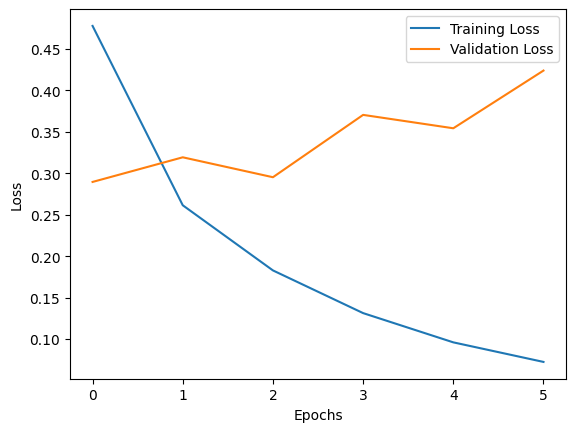

In [62]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [63]:
train_loss, train_accuracy = cnnmodel.evaluate(x_train_seq, y_train, verbose=0)
val_loss, val_accuracy = cnnmodel.evaluate(x_val_seq, y_validation, verbose=0)

print(f"Train Set Error: {train_loss* 100:.2f}%")
print(f"Validation Set Error: {val_loss* 100:.2f}%")

Train Set Error: 23.53%
Validation Set Error: 28.97%


In [64]:
y_pred_proba = cnnmodel.predict(x_test_seq)
y_pred = np.argmax(y_pred_proba, axis=1)
y_pred

99/99 [==============================] - 1s 6ms/step


array([2, 2, 2, ..., 1, 0, 0], dtype=int64)

## Evaluation

In [65]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy_train: {accuracy_score(y_train, np.argmax(cnnmodel.predict(x_train_seq), axis=1))}')
print(f'Accuracy_test: {accuracy:.4f}')
precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1-score: {f1:.4f}')

# In ra báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, y_pred))

530/530 [==============================] - 3s 6ms/step
Accuracy_train: 0.9256305747533817
Accuracy_test: 0.8797
Precision: 0.8822
Recall: 0.8797
F1-score: 0.8800
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1409
           1       0.38      0.39      0.39       167
           2       0.94      0.88      0.91      1590

    accuracy                           0.88      3166
   macro avg       0.73      0.74      0.73      3166
weighted avg       0.88      0.88      0.88      3166



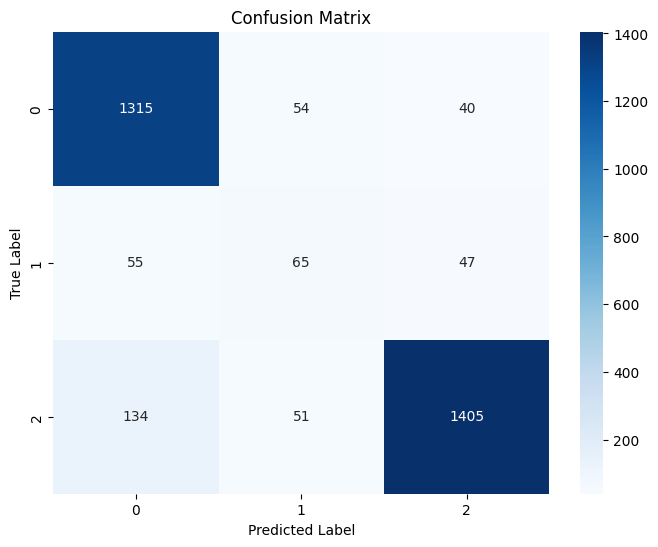

      0   1     2
0  1315  54    40
1    55  65    47
2   134  51  1405


In [66]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
print(pd.DataFrame(cm))